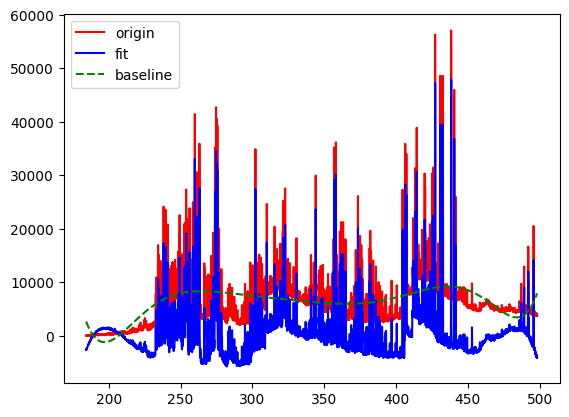

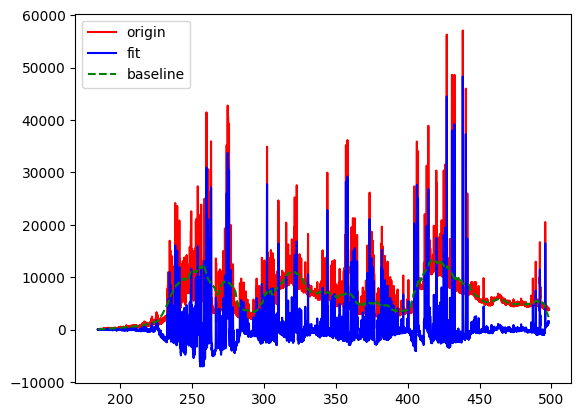

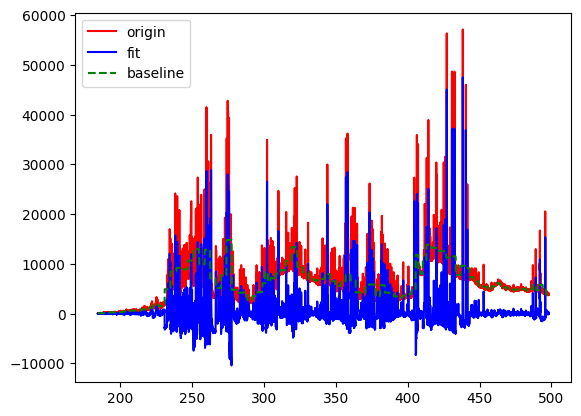

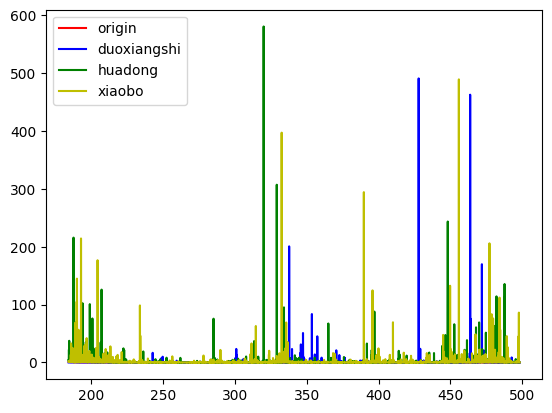

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import os
example_path = r'D:\repeatbility'
file_path = []

'''取路径'''
path = os.walk(example_path)
for files in os.listdir(example_path):
    if files.endswith('txt'):
        file_path.append(example_path+'\\'+files) 

'''读文件'''
wl = np.loadtxt(file_path[0])[:,0].astype(float)
spec_list = []
for paths in file_path:
    spec_list.append(np.loadtxt(paths)[:,1].astype(float))
raw_spec = np.array(spec_list).T
'''写函数'''
def polynomial_baseline_correction(x, y, degree=3):
    """
    总说明
    x - 光谱的波长或频率
    y - 光谱的强度
    degree - 多项式的阶数
    校正后的光谱
    """
    coeffs = np.polyfit(x, y, degree)
    baseline = np.polyval(coeffs, x)
    corrected_spectrum = y - baseline
    
    return corrected_spectrum, baseline

def moving_average_baseline_correction(x, y, window=50):
    baseline = np.convolve(y, np.ones(window)/window, mode='same')
    corrected_spectrum = y - baseline
    return corrected_spectrum, baseline

def manual_wavelet_baseline_correction(x, y, level=3):

    def next_power_of_2(n):#光谱长度不是2的level次方的整数倍，将其补齐。
        return 1 if n == 0 else 2**(n - 1).bit_length()
    
    def haar_wavelet_transform(signal, levels):
        """多级一维Haar小波变换"""
        output = []
        current_signal = signal
        for _ in range(levels):
            half = len(current_signal) // 2
            approx = (current_signal[:2*half:2] + current_signal[1:2*half:2]) / 2
            detail = (current_signal[:2*half:2] - current_signal[1:2*half:2]) / 2
            output.append(detail)
            current_signal = approx
        output.append(current_signal)
        return output[::-1]

    def inverse_haar_wavelet_transform(transformed):
        """ 多级一维Haar小波逆变换 """
        signal = transformed[0]
        for detail in transformed[1:]:
            signal = np.repeat(signal, 2)
            signal[:len(detail)] += detail
            signal[len(detail):] -= detail
        return signal
    
    original_length = len(y)
    target_length = next_power_of_2(original_length)
    padded_y = np.pad(y, (0, target_length - original_length), 'constant')

    transformed = haar_wavelet_transform(padded_y, level)

    for i in range(1, len(transformed)):
        transformed[i] = np.zeros_like(transformed[i])

    baseline = inverse_haar_wavelet_transform(transformed)[:original_length]
    corrected_spectrum = y - baseline
    return corrected_spectrum, baseline

'''求变换结果'''
PBC_spec = np.zeros(raw_spec.shape)
PBC_baseline = np.zeros(raw_spec.shape)
MABC_spec = np.zeros(raw_spec.shape)
MABC_baseline = np.zeros(raw_spec.shape)
MWBC_spec = np.zeros(raw_spec.shape)
MWBC_baseline = np.zeros(raw_spec.shape)

for i in range(len(file_path)):

    PBC_spec[:,i],PBC_baseline[:,i] = polynomial_baseline_correction(wl,raw_spec[:,i],degree=8)
    MABC_spec[:,i],MABC_baseline[:,i] = moving_average_baseline_correction(wl,raw_spec[:,i],window=200)#window越小越过拟合
    MWBC_spec[:,i],MWBC_baseline[:,i] = manual_wavelet_baseline_correction(wl,raw_spec[:,i],level=6)#level越大越过拟合


'''算rsd'''
def RSD_calculate(spec,n):#算RSD
    #导入对应一个波长的所有光谱数据，平均将光谱分为n份的数量
    X_ave = [0 for _ in range(n)]
    every_ave_num = (len(spec)//n)
    sample = np.random.choice(a = every_ave_num*n,size = every_ave_num*n,replace=False,p=None)#无放回抽样
    for i in range(n):
        x_sum = 0
        list_num = i * every_ave_num
        for j in range(list_num,list_num + every_ave_num):
            x_sum += spec[sample[j]]
        X_ave[i] = x_sum/every_ave_num
    RSD = np.sqrt(((X_ave - np.mean(X_ave))**2).sum()/(n-1)) / np.mean(X_ave)
    return abs(RSD)

origin_rsd = []
P_rsd = []
MA_rsd = []
MW_rsd = []
specnum = len(raw_spec[0,:])
for lens in range(len(wl)):
    origin_rsd.append(RSD_calculate(raw_spec[lens,:],specnum))
    P_rsd.append(RSD_calculate(PBC_spec[lens,:],specnum))
    MA_rsd.append(RSD_calculate(MABC_spec[lens,:],specnum))
    MW_rsd.append(RSD_calculate(MWBC_spec[lens,:],specnum))


plt.figure(1)
plt.plot(wl,raw_spec[:,0],c='r',label = 'origin')
plt.plot(wl,PBC_spec[:,0],c='b',label = 'fit')
plt.plot(wl,PBC_baseline[:,0],c='g',label = 'baseline',linestyle='--')
plt.legend()
plt.show()
plt.figure(2)
plt.plot(wl,raw_spec[:,0],c='r',label = 'origin')
plt.plot(wl,MABC_spec[:,0],c='b',label = 'fit')
plt.plot(wl,MABC_baseline[:,0],c='g',label = 'baseline',linestyle='--')
plt.legend()
plt.show()
plt.figure(3)
plt.plot(wl,raw_spec[:,0],c='r',label = 'origin')
plt.plot(wl,MWBC_spec[:,0],c='b',label = 'fit')
plt.plot(wl,MWBC_baseline[:,0],c='g',label = 'baseline',linestyle='--')
plt.legend()
plt.show()
plt.figure(4)
plt.plot(wl,origin_rsd,c='r',label = 'origin')
plt.plot(wl,P_rsd,c='b',label = 'duoxiangshi')
plt.plot(wl,MA_rsd,c='g',label = 'huadong')
plt.plot(wl,MW_rsd,c='y',label = 'xiaobo')

plt.legend()
plt.show()

In [128]:
example_path = r'D:\corrected'
file_path = []
'''取路径'''
path = os.walk(example_path)
for files in os.listdir(example_path):
    if files.endswith('txt'):
        file_path.append(example_path+'\\'+files) 

'''读文件'''
wl = np.loadtxt(file_path[0])[:,0].astype(float)
spec_list = []
for paths in file_path:
    spec_list.append(np.loadtxt(paths)[:,1].astype(float))
raw_spec2 = np.array(spec_list).T

In [129]:
baoluo = []
for lens in range(len(wl)):
    baoluo.append(RSD_calculate(raw_spec2[lens,:],specnum))

In [130]:
a = np.vstack((wl,origin_rsd,baoluo,P_rsd,MA_rsd,MW_rsd)).T

In [131]:
np.savetxt(example_path + '\\' + 'result.csv',a,delimiter=',')